# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the OPEC Oil Prices Data

### 1. Importing libraries and data

In [1]:
import nasdaqdatalink
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of the statsmodels, which is a library the handles 
# statistical models
import os
import warnings # This is a library that handles warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended Library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how the plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Importing data (Organization of Petroleum exporting countries)
# Data source: https://data.nasdaq.com/databases/OPEC

path = r'C:\Users\terry\Documents\Data Analytics Course\Achievement 6'

In [3]:
df = pd.read_csv(os.path.join(path, 'Original Data', 'QDL_OPEC.csv'))

In [4]:
df.head()

,date,value
0,2024-01-25,81.98
1,2023-12-04,79.63
2,2023-12-01,82.54
3,2023-11-30,85.00
4,2023-11-29,83.89


In [5]:
# Convert the 'date' column to datetime format

df['date'] = pd.to_datetime(df['date'])

In [7]:
# Sort the data by date (if not already sorted)
df = df.sort_values('date')

In [8]:
df.head()

,date,value
5434,2003-01-02,30.05
5433,2003-01-03,30.83
5432,2003-01-06,30.71
5431,2003-01-07,29.72
5430,2003-01-08,28.86


In [9]:
df.shape

(5435, 2)

In [10]:
df.columns

Index(['date', 'value'], dtype='object')

In [11]:
type(df)

pandas.core.frame.DataFrame

In [13]:
# Setting the date as the index column

df.set_index('date', inplace=True)
df.head()

,value
date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


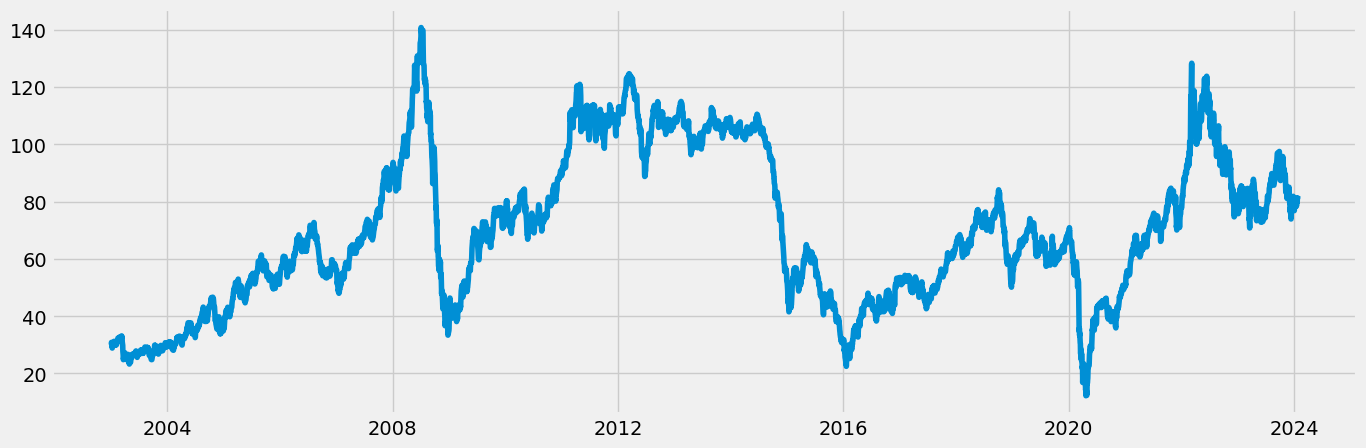

In [14]:
# Plot the data
plt.figure(figsize=(15, 5))

plt.plot(df)

### 2. Subsetting, wrangling and cleaning of time-series data

In [15]:
# Reset index to use the "Date" column as a filter

df_2 = df.reset_index()

In [16]:
df_2.head()

,date,value
0,2003-01-02,30.05
1,2003-01-03,30.83
2,2003-01-06,30.71
3,2003-01-07,29.72
4,2003-01-08,28.86


In [17]:
df_2.columns

Index(['date', 'value'], dtype='object')

In [19]:
df_sub = df_2.loc[(df_2['date'] >= '2010-01-01') & (df_2['date'] < '2020-01-01')]

In [21]:
df_sub.shape

(2579, 2)

In [22]:
df_sub.head()

,date,value
1806,2010-01-04,78.23
1807,2010-01-05,79.14
1808,2010-01-06,79.70
1809,2010-01-07,80.19
1810,2010-01-08,79.94


In [23]:
# Set the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['date']) # Create a datetime column from "Date.""
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,value
datetime,
2010-01-04,78.23
2010-01-05,79.14
2010-01-06,79.70
2010-01-07,80.19
2010-01-08,79.94


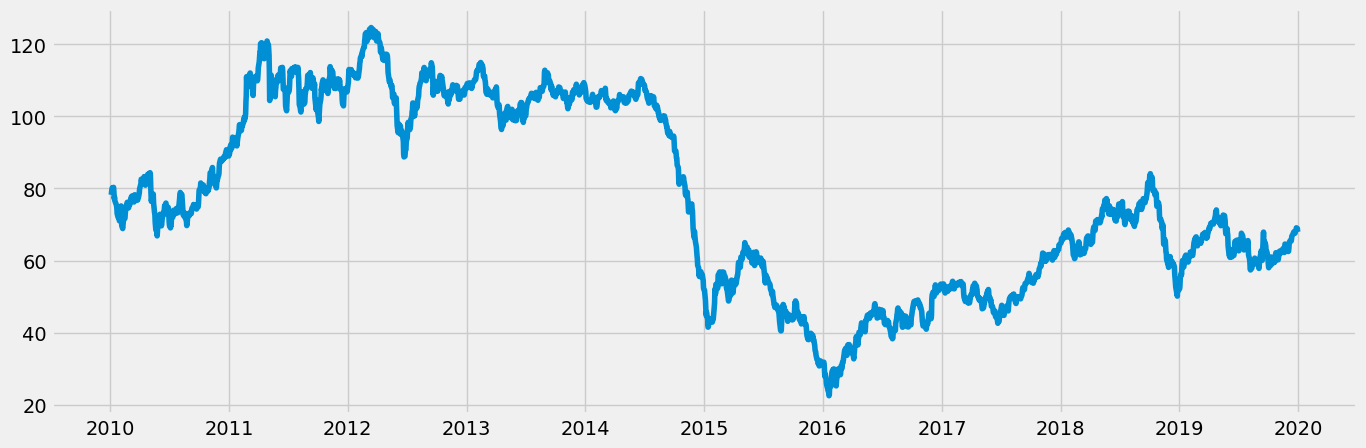

In [24]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

In [25]:
# Checking missing values

df_sub.isnull().sum()

value    0
dtype: int64

In [27]:
# Checking for duplicates

dups = df_sub.duplicated()
dups.sum()

433

Handling of duplicates

In [29]:
# Counting duplicate timestamps

print(df_sub.index.duplicated().sum())

0


In [31]:
# showing all duplicated timestamps

duplicates = df_sub[df_sub.index.duplicated(keep=False)]
print(duplicates)

# Empty DataFrame indicates Timestamps are 'UNIQUE' and not timestamp related

Empty DataFrame
Columns: [value]
Index: []


In [32]:
# Checking all duplicate rows

duplicates_2 = df_sub[df_sub.duplicated(keep=False)]
print(duplicates_2.head(20))

            value
datetime         
2010-01-18  75.75
2010-01-28  71.40
2010-01-29  71.01
2010-02-01  71.02
2010-02-02  73.05
2010-02-23  75.75
2010-02-25  74.66
2010-03-01  75.75
2010-03-02  75.51
2010-03-05  77.27
2010-03-16  76.62
2010-03-17  78.25
2010-04-06  82.55
2010-04-07  82.36
2010-04-09  81.97
2010-04-15  83.28
2010-04-22  82.36
2010-04-30  84.13
2010-05-17  73.25
2010-05-19  70.57


In [33]:
# Checking the frequency of 'value'column entries

print(df_sub["value"].value_counts())

value
106.79    5
44.34     5
111.20    4
73.05     4
72.49     4
         ..
99.79     1
98.33     1
101.40    1
103.78    1
67.96     1
Name: count, Length: 2146, dtype: int64


Since all timestamps are unique, this leaves us with the only explanation that the duplicates are from the 'value' column as seen above. Since these repeated values appear at uniquely different timestamps, i won't be dropping them.

#### Detecting Missing Dates 
##### Checking if there are gaps or inconsistent frequency in the date sequence since this is crucial for time series decomposition analysis

In [41]:
# Generating a complete date range

full_date_range = pd.date_range(start=df_sub.index.min(), end=df_sub.index.max(), freq='D')

In [46]:
# Identifying missing dates

missing_dates = full_date_range.difference(df.index)
print(f"Missing dates: {missing_dates}")

Missing dates: DatetimeIndex(['2010-01-09', '2010-01-10', '2010-01-16', '2010-01-17',
               '2010-01-23', '2010-01-24', '2010-01-30', '2010-01-31',
               '2010-02-06', '2010-02-07',
               ...
               '2019-12-01', '2019-12-07', '2019-12-08', '2019-12-14',
               '2019-12-15', '2019-12-21', '2019-12-22', '2019-12-25',
               '2019-12-28', '2019-12-29'],
              dtype='datetime64[ns]', length=1070, freq=None)


In [47]:
# Reindex to include all dates and forward-fill missing values

df_sub = df_sub.reindex(full_date_range).rename_axis('date')
df_sub['value'] = df_sub['value'].ffill()  # Forward-fill

In [48]:
# Checking if any dates are still missing

assert df_sub.index.equals(full_date_range), "Dates are still missing!"

In [50]:
# Resetting the index and saving the cleaned data:

df_sub = df_sub.reset_index()  # Move date back to a column
df_sub.to_csv(os.path.join(path,'Prepared Data', 'QDL_OPEC_cleaned.csv'))

In [51]:
df_sub.shape

(3649, 3)

In [52]:
df_sub.head()

,index,date,value
0,0,2010-01-04,78.23
1,1,2010-01-05,79.14
2,2,2010-01-06,79.70
3,3,2010-01-07,80.19
4,4,2010-01-08,79.94


In [53]:
# Set the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['date']) # Create a datetime column from "Date.""
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,index,value
datetime,,
2010-01-04,0,78.23
2010-01-05,1,79.14
2010-01-06,2,79.70
2010-01-07,3,80.19
2010-01-08,4,79.94


In [54]:
df_sub.columns

Index(['index', 'value'], dtype='object')

In [55]:
# Dropping the index column

df_sub = df_sub.drop("index", axis=1)

In [60]:
df_sub.head()

,value
datetime,
2010-01-04,78.23
2010-01-05,79.14
2010-01-06,79.70
2010-01-07,80.19
2010-01-08,79.94


#### Grouping the data quarterly

In [83]:
# Smoothening out data by grouping it quarterly before conducting the time series analysis
# Grouping the data quarterly will avoid unneccessary variations and smoothen the data more.

df_sub = df_sub['value'].resample('Q').mean()

In [84]:
# Checking resampled df_sub data
df_sub.head()

datetime
2010-03-31     75.368046
2010-06-30     76.603846
2010-09-30     73.717609
2010-12-31     83.725978
2011-03-31    101.004111
Freq: QE-DEC, Name: value, dtype: float64

In [93]:
# Giving the values column a name;
df_sub = df_sub.to_frame().rename(columns={'value':'value'})

In [94]:
df_sub.head()

,value
datetime,
2010-03-31,75.368046
2010-06-30,76.603846
2010-09-30,73.717609
2010-12-31,83.725978
2011-03-31,101.004111


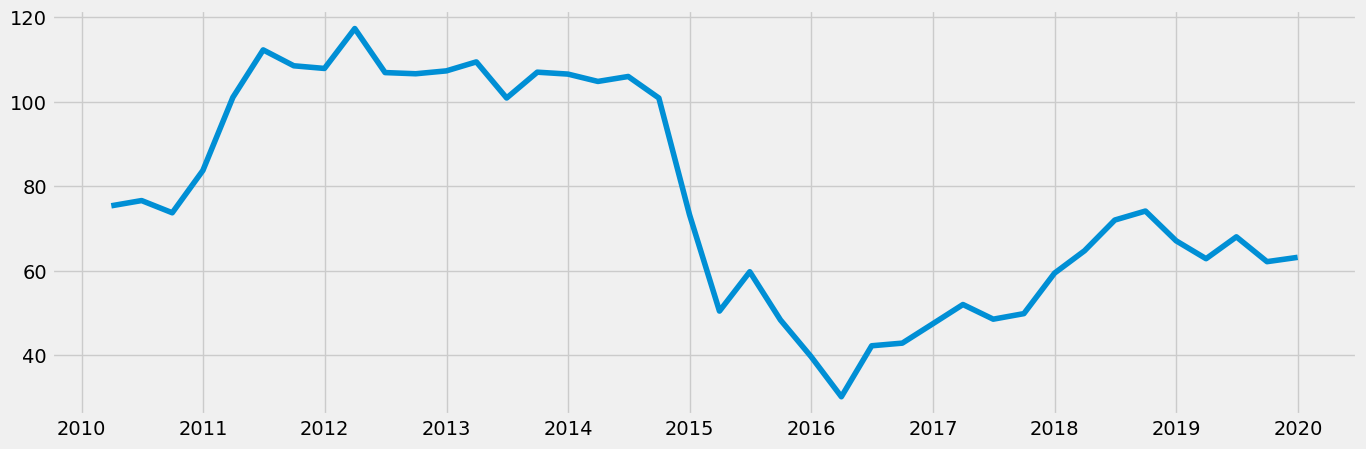

In [95]:
# Plotting the new resampled data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

#### Observation:
The data suggests a somewhat trend from mid 2011 to mid 2014 followed by a unit root by the 3rd quarter of 2014 up until the 1st quarter of 2015 and again from mid 2015 to the 1st quarter of 2016. From there on, an upward trend with slight variations is noticed up until 2020. 

### 3. Time-series analysis: decomposition

In [96]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive', period=12)

In [97]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

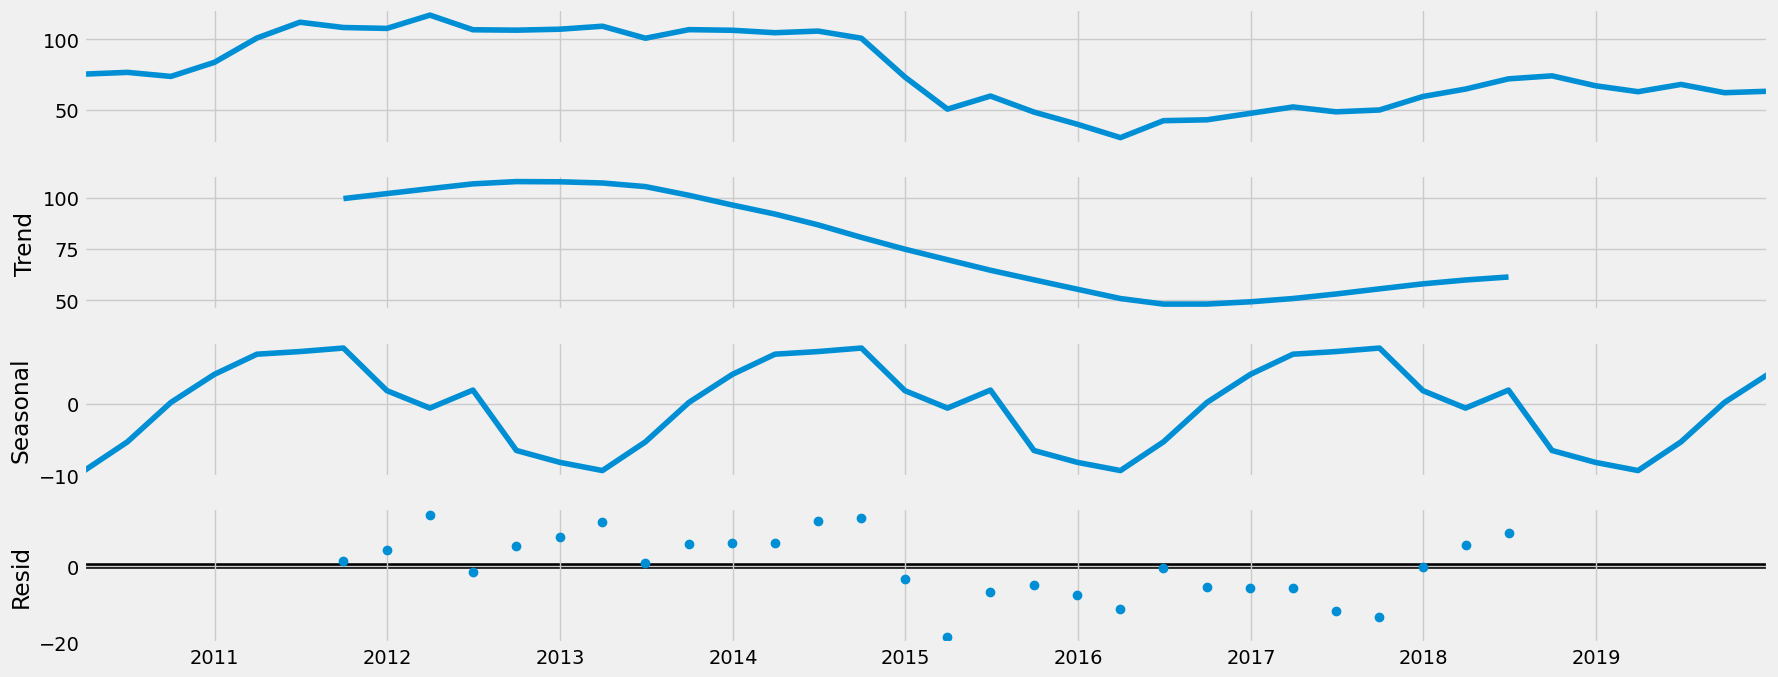

In [98]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Observations: 
* The data suggests a very strong seasonality with peaks and lows (with almost identical values) at 3-year regular intervals 
* There has been more of a downward trend since mid 2013 up until mid 2016, then a slight rebounce afterwards. Generally speaking, oil prices did experience a downward trend overall up until 2020.
* As a result of the overall downward trend, the data is non-stationary.
* Further testing is warranted.

### 4. Testing for stationarity

#### Establishing the null Hypothesis.

Though there is no consistent downward or upward trend to suggest strong non-stationarity at first glance, there is also no evidence of a stationary time series since the mean or variance aren't constant over time.

Null Hypothesis: The presence of a unit root (which will mean the data is stationary)


In [99]:
# The adfuller() function will import from the model from statmodels for the test; however, running it will only return
# an array of numbers. This is why a function that prints the correct output from that array must be defined.

from statsmodels.tsa.stattools import adfuller # Imports the adfuller function

def dickey_fuller(timeseries): # Defining the function
    # performing the Dickey-fuller test:
    print ('Dickey-Fuller Stationarity test')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
        print (result)

# Applying the test using the function of the time series
dickey_fuller(df_sub['value'])

Dickey-Fuller Stationarity test
Test Statistic                 -0.995802
p-value                         0.754792
Number of Lags Used             0.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
dtype: float64
Test Statistic                 -0.995802
p-value                         0.754792
Number of Lags Used             0.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
dtype: float64
Test Statistic                 -0.995802
p-value                         0.754792
Number of Lags Used             0.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


#### Interpretation of the Stationarity test
Comparing the test statistic to the critical values of the significance levels of 5% and 10%, the null hypothesis can't be rejected since the statistic test value is larger than the critical values of the two signifance levels. This means there is a unit root in the data which is what had been guessed looking at the chart hence confirming non-stationarity in the data. 
Also, A “significant” result would be a p-value of less than 0.05, but clearly in this test, the p-value is 0.755 - way more than 0.05.

### 5. Stationarizing the OPEC Crude Oil Prices Data

In [100]:
data_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t-(t -1)

In [101]:
data_diff.dropna(inplace = True) # Removing the missing value that about as a result of the differencing.
# These values must be removed otherwise the Dickey-Fuller test can't be run

In [102]:
data_diff.head()

,value
datetime,
2010-06-30,1.235800
2010-09-30,-2.886237
2010-12-31,10.008370
2011-03-31,17.278133
2011-06-30,11.219845


In [103]:
data_diff.columns

Index(['value'], dtype='object')

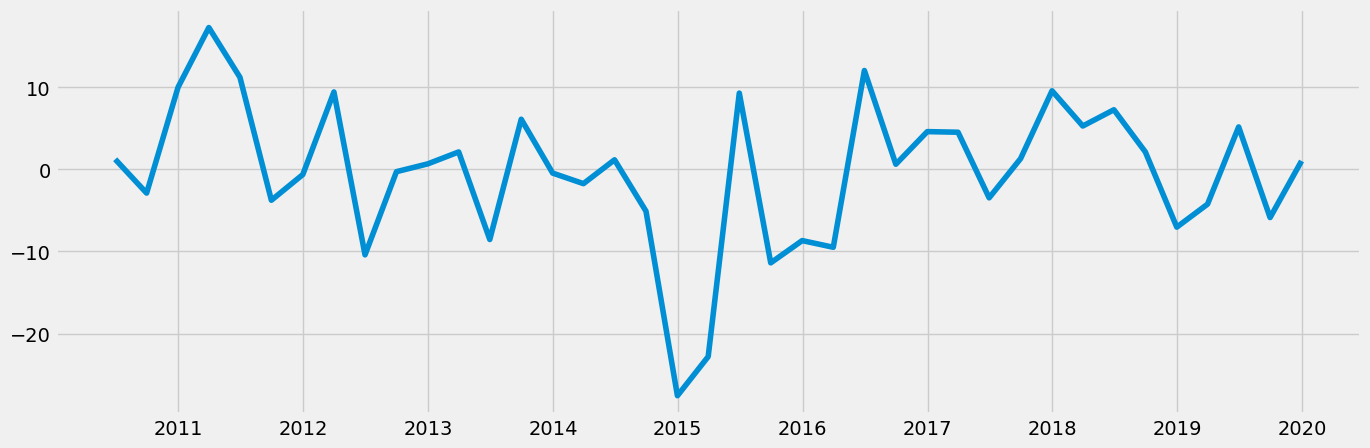

In [104]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [105]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test
Test Statistic                 -4.732195
p-value                         0.000073
Number of Lags Used             0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
dtype: float64
Test Statistic                 -4.732195
p-value                         0.000073
Number of Lags Used             0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
dtype: float64
Test Statistic                 -4.732195
p-value                         0.000073
Number of Lags Used             0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


### Interpretation after Stationarizing

Perfect! The test statistic is now smaller than the critical value at both the 5% and 10% significance levels. There is also a satisfactory p-value of less than 0.05. This means the null hypothesis can be rejected and, as a result, the time series can be considered stationary.

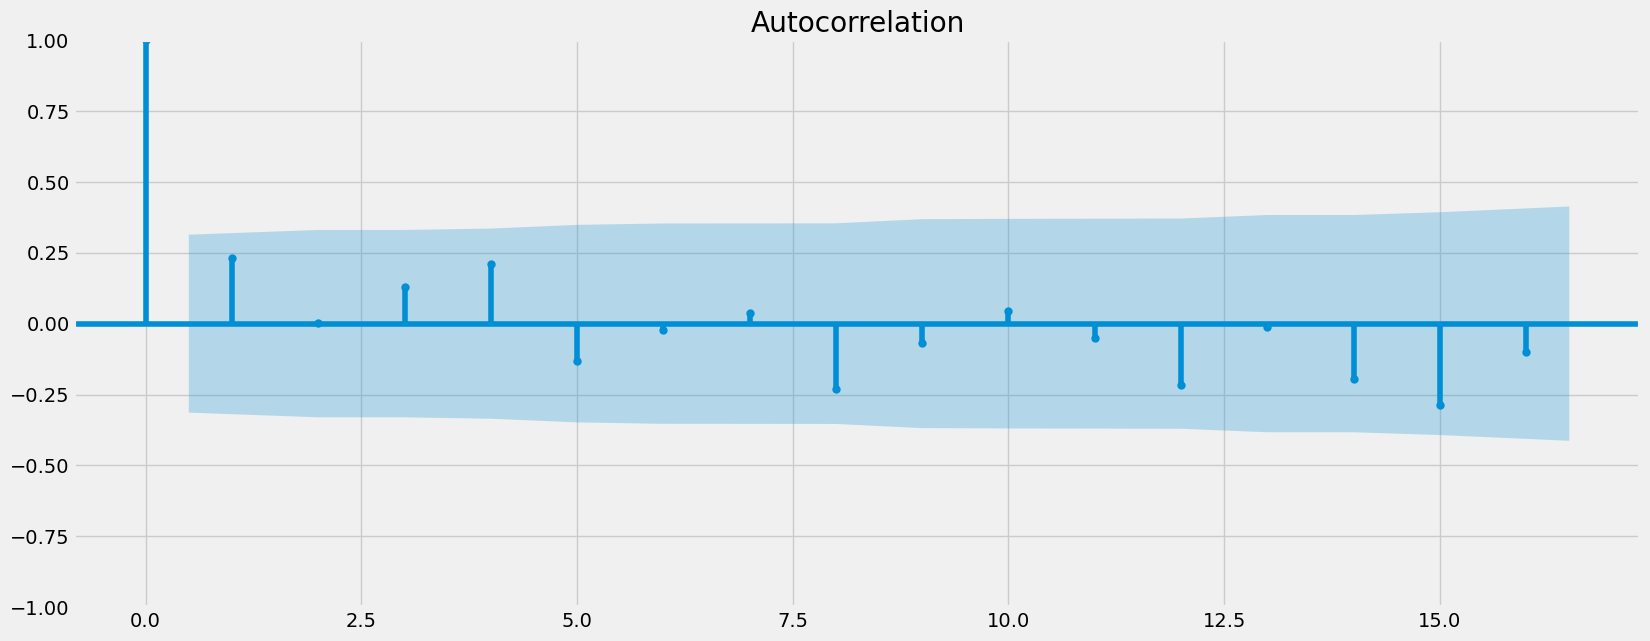

In [106]:
# Checking data's autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Importing the autocorrelation and partial correlation plots

plot_acf(data_diff)
plt.show()

#### Interpretation of autocorrelation

The OPEC prices data has only 1 lag that goes beyond the confidence level and not correlated to any other. There isn't any autocorrelated data and the set is likely stationary, which supports the result of the Dickey-Fuller test conducted above. Now, the data is ready for forecasting.